## **Lab # 1**
_Tream 5_ <br>
_Kozlyak Ruslan, Shmelev Egor, Vysotskiy Roman_

## **Dataset representation**

### **We use the following dataset from Kaggle. Here some description about dataset:**

#### This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
#### There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.
#### About the currency for the price column: it is Price ($)
#### And About the columns x,y, and z they are diamond measurements as (( x: length in mm, y: width in mm,z: depth in mm )).


#### https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

## **Import libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from tqdm import tqdm
import math
from scipy.optimize import least_squares, minimize
import scipy.stats as st
from scipy.stats import betabinom
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## **1) Data overviewing**

In [4]:
data = pd.read_csv('Diamonds Prices2022.csv', index_col=0)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53943 entries, 1 to 53943
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


### Here we can see that in data there are no null values. The majority of data are presented in float type, but there is object and int types too. So we have to label columns with object type of data, lets do this

In [6]:
print(f'For column Cut there are - {data["cut"].nunique()} unique values ({data["cut"].unique()})')
print(f'For column Color there are - {data["color"].nunique()} unique values ({data["color"].unique()})')
print(f'For column Carity there are - {data["clarity"].nunique()} unique values ({data["clarity"].unique()})')

For column Cut there are - 5 unique values (['Ideal' 'Premium' 'Good' 'Very Good' 'Fair'])
For column Color there are - 7 unique values (['E' 'I' 'J' 'H' 'F' 'G' 'D'])
For column Carity there are - 8 unique values (['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF'])


### Dataset has various categorical features and for each of them we should apply Label Encoding

In [73]:
cut_factor = pd.factorize(data['cut'])
data['cut'] = cut_factor[0]

color_factor = pd.factorize(data['color'])
data['color'] = color_factor[0]

color_factor = pd.factorize(data['clarity'])
data['clarity'] = color_factor[0]

In [74]:
data

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,0,0,0,61.5,55.0,326,3.95,3.98,2.43
2,0.21,1,0,1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,2,0,2,56.9,65.0,327,4.05,4.07,2.31
4,0.29,1,1,3,62.4,58.0,334,4.20,4.23,2.63
5,0.31,2,2,0,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53939,0.86,1,3,0,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,0,6,0,62.2,55.0,2757,5.83,5.87,3.64
53941,0.71,1,0,1,60.5,55.0,2756,5.79,5.74,3.49
53942,0.71,1,4,1,59.8,62.0,2756,5.74,5.73,3.43


### Now as you can see our several columns with object type have numbers instead of strings.

In [6]:
y = data.price
x = data.drop(['price'], axis='columns')

## **2) Non-parametric estimation of PDF in form of histogram and using kernel density function / probability law**

In [7]:
continious_cols = ["carat", "depth", "table", "x", "y", "z"]
discrite_cols = ["cut","color", "clarity"]

rows_count, columns_count = x.shape

3it [00:00, 24.06it/s]


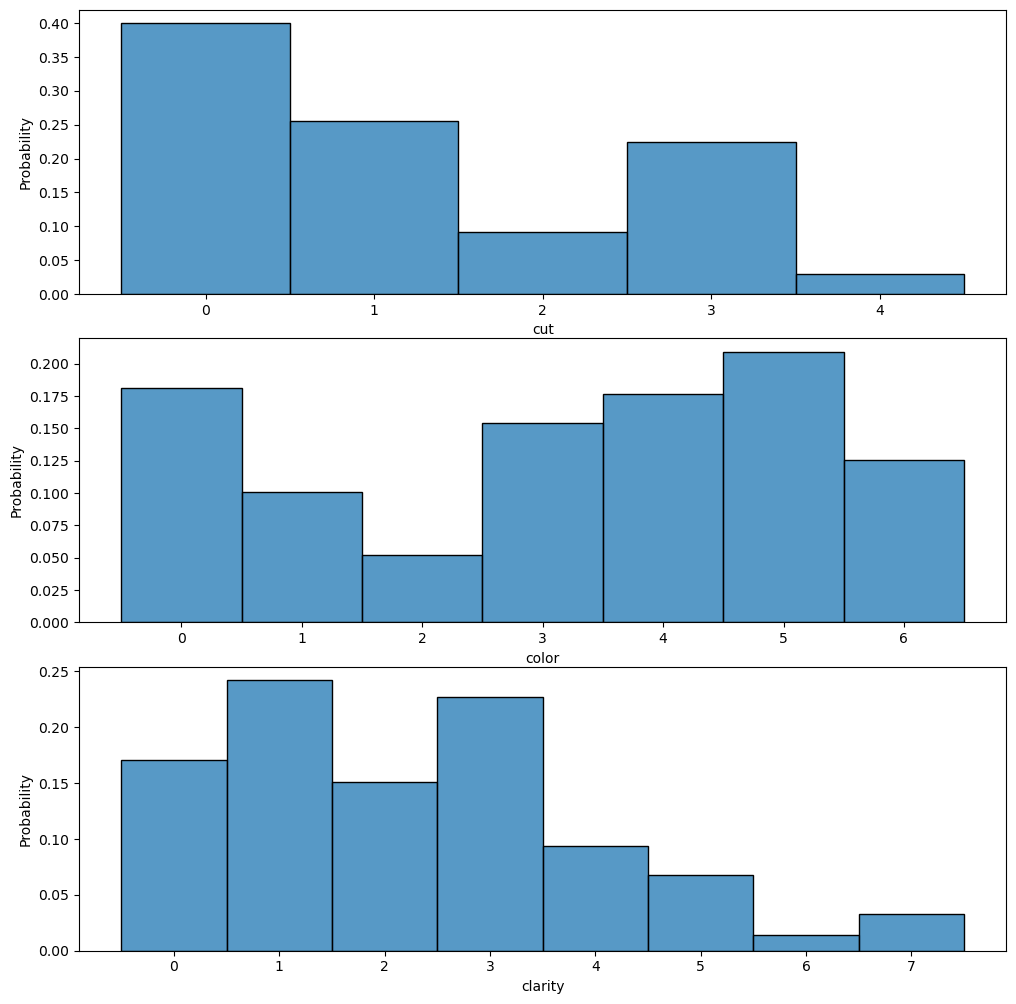

In [8]:
nrows=len(discrite_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,  nrows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(discrite_cols)):
    sns.histplot(x[column], ax=axes[i], stat="probability", discrete=True)

### As we known from method info() presented columns (cut, color, clarity) are categorical. So for this features we use probability law and that is why there is no kde plot for them.
### Look through 

6it [00:00,  7.09it/s]


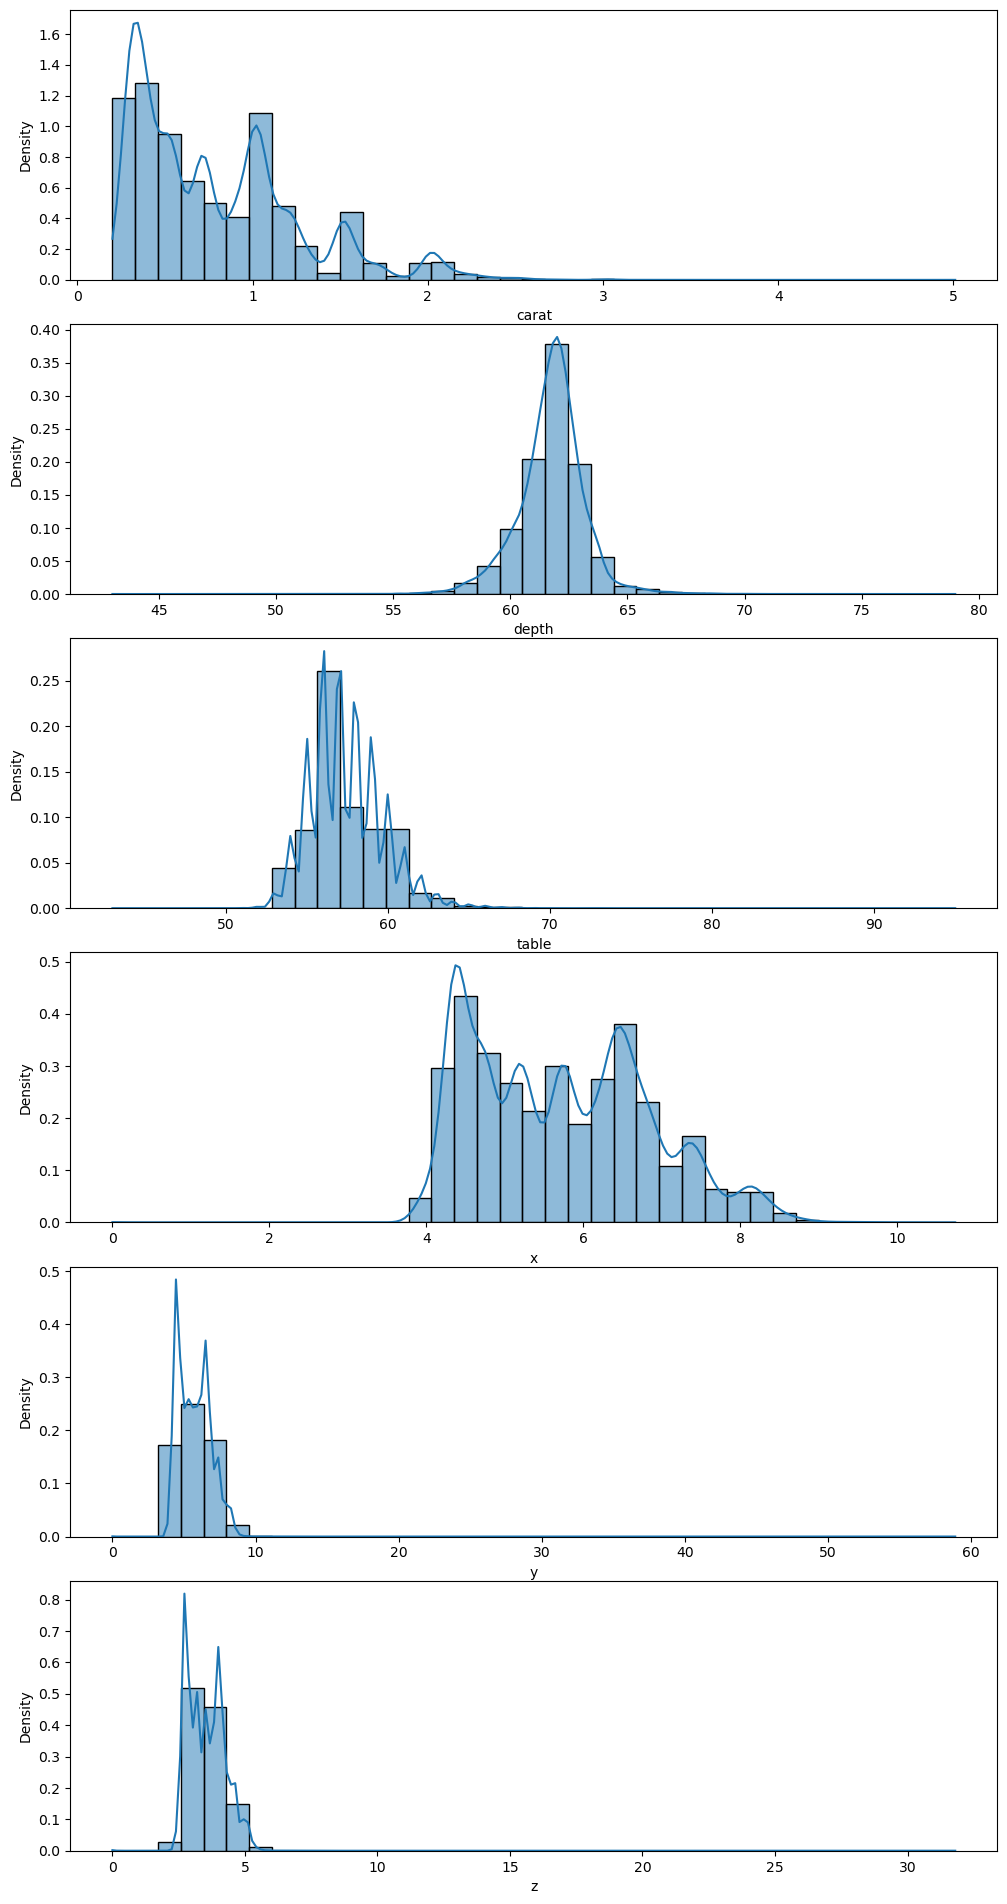

In [9]:
nrows=len(continious_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,  nrows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(continious_cols)):
    sns.histplot(x[column], ax=axes[i], kde=True, stat="density", bins=int(1 + 3.32 * math.log(rows_count)))

### 

## **3) Estimation of order statistics and represent them as “box with whiskers” plot**

9


9it [00:00, 15.72it/s]


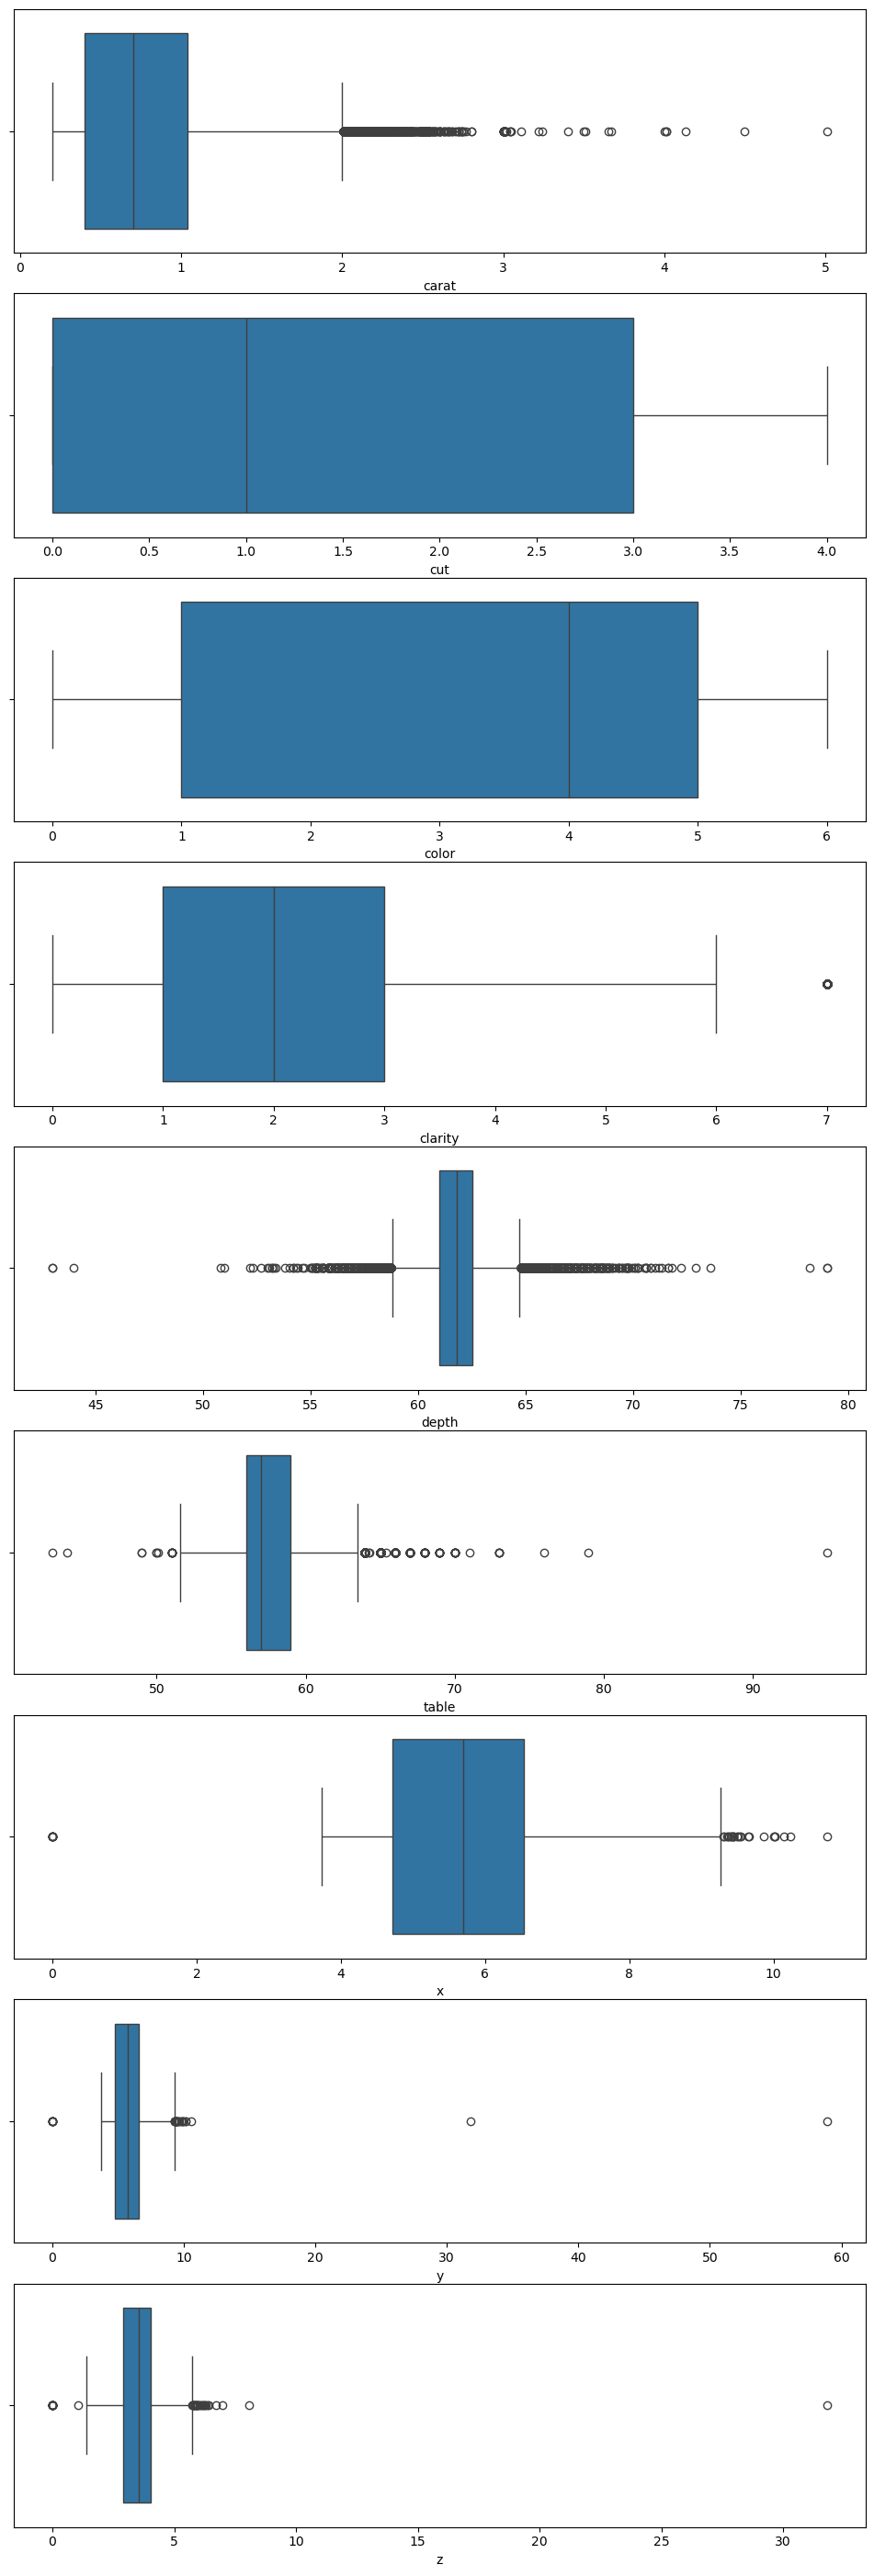

In [10]:
n_rows = len(x.columns)
print(n_rows)
fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10, n_rows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(x)):
    sns.boxplot(data=x, x=column, ax=axes[i])

## **4) Theoretical distributions that could describe the sample with step 5**
## **5) Parameters estimation of chosen distributions using methods of maximum likelihood and least squares method**

In [11]:
# leave 4 continuous features and 1 categorical feature
data_main = data.copy()
data_main.drop(columns=['y','z','price'], inplace=True)
data_cl = data['clarity']

### Here we drop some columns of continues features and separate 1 categorical feature

For carat: Best fit distribution: lognorm
MLE parameters: (0.8700674623769711, 0.18150624656161904, 0.44182390861417203)
Least Squares parameters: [3.00350179 0.29991298 0.69531469]



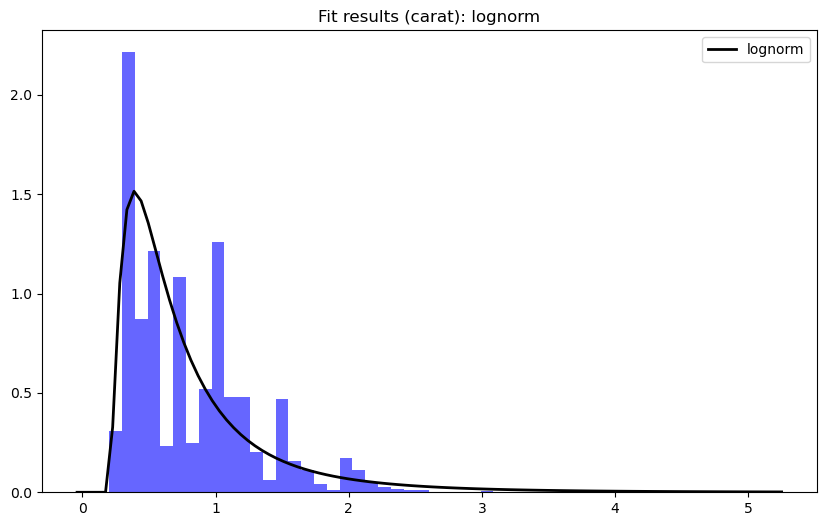

For depth: Best fit distribution: beta
MLE parameters: (137702.86053399573, 28819.85473259415, -1216.048792072555, 1545.2286988299743)
Least Squares parameters: [137590.66674438  28191.61969684   -914.86965044   1176.8743967 ]



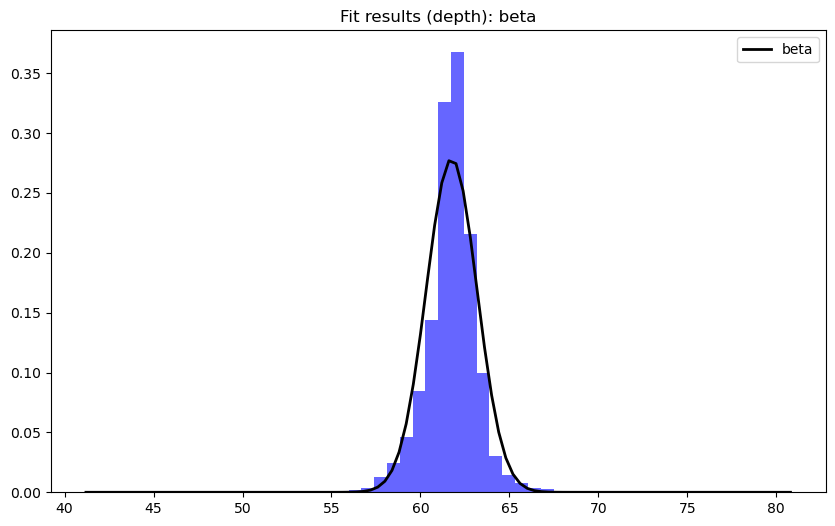

For table: Best fit distribution: lognorm
MLE parameters: (0.1339179418108062, 41.12459577997278, 16.18553423070972)
Least Squares parameters: [ 0.24340232 48.33124192  8.89518828]



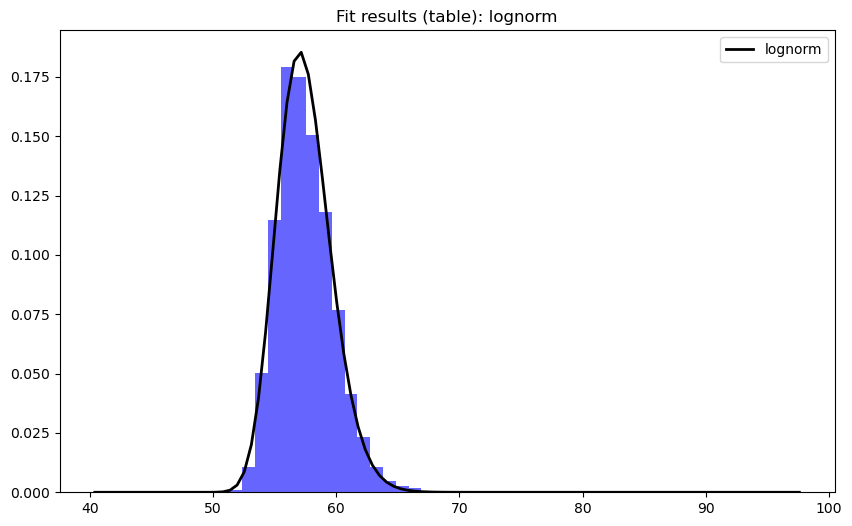

For x: Best fit distribution: weibull_min
MLE parameters: (1.867651466015043, 3.7293996210523885, 2.2593706306570294)
Least Squares parameters: [1.38983379 3.94898999 2.14400208]



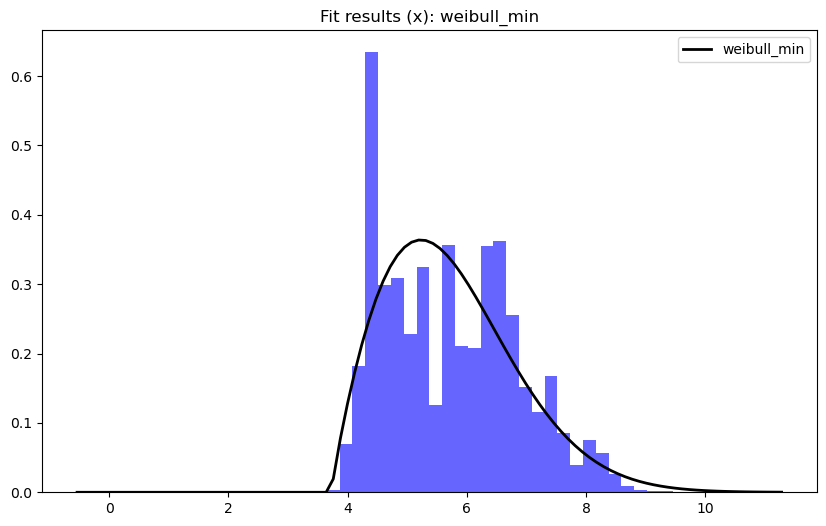

In [47]:
# continious features
# 1. detection of best distribution:
DISTRIBUTIONS = [
    st.norm, # Normal distribution
    st.expon, # Exponential distribution
    st.gamma, # Gamma distribution
    st.beta, # Beta distribution
    st.lognorm, # Lognormal distribution
    st.uniform, # Uniform distribution
    st.t, # Student's t-distribution
    st.chi2, # Chi-squared distribution
    st.weibull_min, # Weibull distribution (minimum)
    st.pareto # Pareto distribution
]

def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    distributions = DISTRIBUTIONS
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    best_distribution = None
    best_params = None
    best_sse = np.inf

    for distribution in distributions:
        try:
            params = distribution.fit(data)
            pdf = distribution.pdf(bin_centers, *params)
            sse = np.sum(np.power(hist - pdf, 2.0))
            
            if sse < best_sse:
                best_distribution = distribution
                best_params = params
                best_sse = sse
        except:
            continue

    return (best_distribution, best_params)

# 2. Parameters estimation:

def mle_params(distribution, data):
    return distribution.fit(data)

def residuals(params, data, distribution):
    hist, bin_edges = np.histogram(data, bins=len(data), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    expected = distribution.pdf(bin_centers, *params)
    return hist - expected

def ls_params(distribution, data):
    initial_guess = mle_params(distribution, data)
    result = least_squares(residuals, initial_guess, args=(data, distribution))
    return result.x

def plot_best_fit(data, distribution, params, col):
    """Plot original data with best fit distribution."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot original data in histogram
    ax.hist(data, bins=50, density=True, alpha=0.6, color='b')
    
    # Plot the best fit distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf = distribution.pdf(x, *params)
    ax.plot(x, pdf, 'k', linewidth=2, label=distribution.name)
    
    title = f"Fit results ({col}): {distribution.name}"
    ax.set_title(title)
    plt.legend()
    plt.show()

data_samples = {"carat": data_main['carat'] ,"depth": data_main['depth'] ,
                "table": data_main['table'] , "x": data_main['x']}

data_samples_distribution = {} # dictionary with best fitted distribution 

for key, data in data_samples.items():
    best_distribution, best_params = best_fit_distribution(data)
    data_samples_distribution[key] = [best_distribution.name, best_distribution]
    print(f"For {key}: Best fit distribution: {best_distribution.name}")
    
    mle_parameters = mle_params(best_distribution, data)
    print(f"MLE parameters: {mle_parameters}")
    
    ls_parameters = ls_params(best_distribution, data)
    print(f"Least Squares parameters: {ls_parameters}\n")

    data_samples_distribution[key] = [best_distribution.name, best_distribution]
    
    plot_best_fit(data, best_distribution, best_params, col=key)


### For choosen columns we estimated MSE and Least Square values. In addition we found best fitted distribution for each one. The same we made with categorical feature in the next cells

In [16]:
# defining parameters for the categorical feature "clarity"
def neg_log_likelihood(params, data, n):
    a, b = params
    return -np.sum(betabinom.logpmf(data, n, a, b))

n = 7  

# initial values for alpha and beta
initial_params = [1, 1]

result = minimize(neg_log_likelihood, initial_params, args=(data_cl, n), bounds=((0, None), (0, None)))

alpha_mle, beta_mle = result.x
print(f"Alpha (MLE): {alpha_mle}")
print(f"Beta (MLE): {beta_mle}")


Alpha (MLE): 1.5510518105132103
Beta (MLE): 3.2379860745859586


In [17]:
def residuals(params, data, n):
    a, b = params
    observed_freqs = np.bincount(data, minlength=n+1) / len(data)
    expected_probs = betabinom.pmf(np.arange(n+1), n, a, b)
    return np.sum((observed_freqs - expected_probs)**2)

result_ls = minimize(residuals, initial_params, args=(data_cl, n), bounds=((0, None), (0, None)))

alpha_ls, beta_ls = result_ls.x
print(f"Alpha (LS): {alpha_ls}")
print(f"Beta (LS): {beta_ls}")


Alpha (LS): 1.7770919354163384
Beta (LS): 3.8390413786388464


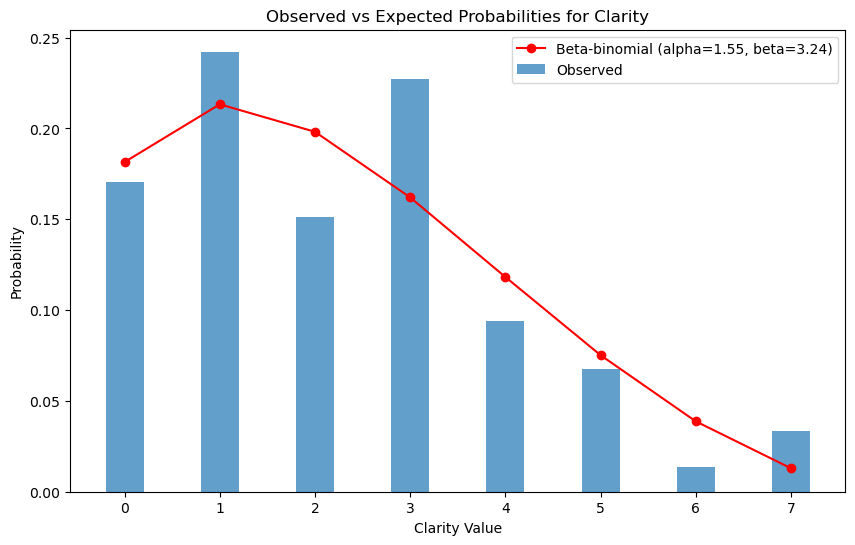

In [15]:
values, counts = np.unique(data_cl, return_counts=True)

probs_observed = counts / counts.sum()

probs_expected = betabinom.pmf(values, n, alpha_mle, beta_mle)

plt.figure(figsize=(10,6))
plt.bar(values, probs_observed, width=0.4, align='center', label='Observed', alpha=0.7)
plt.plot(values, probs_expected, 'o-', color='red', label=f'Beta-binomial (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Clarity Value')
plt.ylabel('Probability')
plt.title('Observed vs Expected Probabilities for Clarity')
plt.xticks(values)
plt.legend()
plt.show()


### As column Clarity is a categorical wi used Beta-binomial distribution. In the result it looks that distribution fits the data.   

## **6) Validation of estimated parameters using QQ biplots**

In [48]:
data_samples_distribution # check dictionary distributions for each column 

{'carat': ['lognorm',
 'depth': ['beta', <scipy.stats._continuous_distns.beta_gen at 0x13ed80f10>],
 'table': ['lognorm',
 'x': ['weibull_min',
  <scipy.stats._continuous_distns.weibull_min_gen at 0x13ed83400>]}

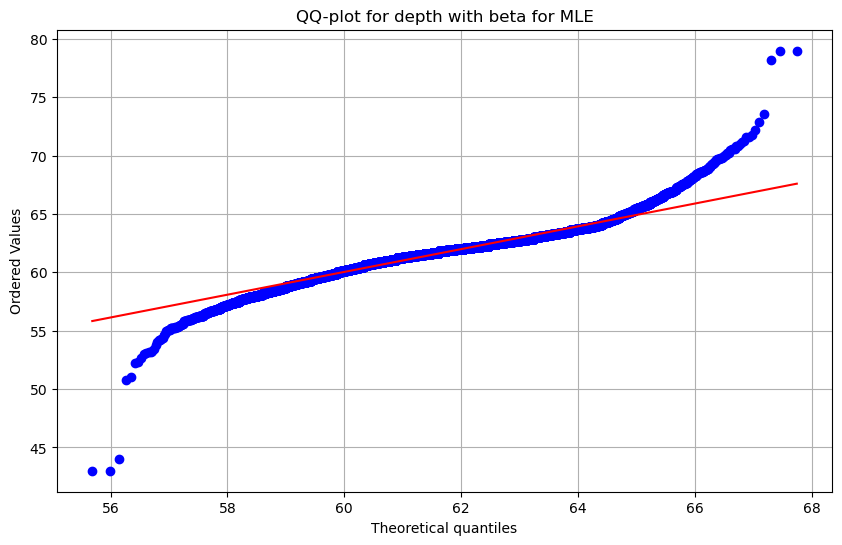

In [88]:
def qq_plot(data, distribution, params, title):
    plt.figure(figsize=(10, 6))
    stats.probplot(data, sparams=params, dist=distribution, plot=plt)
    plt.title(f'QQ-plot for {title}')
    plt.grid()


qq_plot(data_main['depth'], st.beta, mle_params(st.beta, data_main['depth']), 'depth with beta for MLE')

In [95]:
def qq_plot_estimation(data, distribution, column_name, distribution_name):
    # Determination of the parameters of the best-fitted distribution of the average value for specific atributes
    x = np.linspace(np.min(data), np.max(data))

    # The distribution parameters are determined using the fit function based on the maximum likelihood method
    params_mle = distribution.fit(data)
    params_ls = ls_params(distribution, data)

    # Plotting a quantile biplot for empirical and theoretical distribution
    # Building a quantile biplot

    fig, (ax_mle, ax_ls) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'QQ-plot ({column_name}) for {distribution_name} distribution')

    stats.probplot(data, sparams=params_mle, dist=distribution, plot=ax_mle)
    ax_mle.set_title(f'QQ-plot ({column_name}) for MLE')
    ax_mle.grid()

    stats.probplot(data, sparams=params_ls, dist=distribution, plot=ax_ls)
    ax_ls.set_title(f'QQ-plot ({column_name}) for Least Square')
    ax_ls.grid()

    # # Calculation of quantiles
    # percs = np.linspace(0, 100, 21)
    # qn = np.percentile(data, percs)
    # qn_mle = distribution.ppf(percs / 100.0, *params_mle)
    # qn_ls = distribution.ppf(percs / 100.0, *params_ls)


    # # Building a quantile biplot
    # """Plot original data with best fit distribution."""
    # fig, (ax_mle, ax_ls) = plt.subplots(1, 2, figsize=(18, 6))
    # ax_mle.plot(qn, qn_mle, ls="", marker="o", markersize=6)
    # ax_mle.plot(x, x, color="k", ls="--")
    # ax_mle.set_xlabel(f'Empirical distribution')
    # ax_mle.set_ylabel(f'Theoretical ({distribution_name}) distribution')
    # title = f"QQ-plot ({column_name}) for MLE"
    # ax_mle.set_title(title)
    # ax_mle.grid(True)

    # ax_ls.plot(qn, qn_ls, ls="", marker="o", markersize=6)
    # ax_ls.plot(x, x, color="k", ls="--")
    # ax_ls.set_xlabel(f'Empirical distribution')
    # ax_ls.set_ylabel(f'Theoretical ({distribution_name}) distribution')
    # title = f"QQ-plot ({column_name}) for Least Square"
    # ax_ls.set_title(title)
    
    # fig.suptitle(f'QQ-plot ({column_name}) for {distribution_name}')
    # ax_ls.grid(True)
    # plt.show()

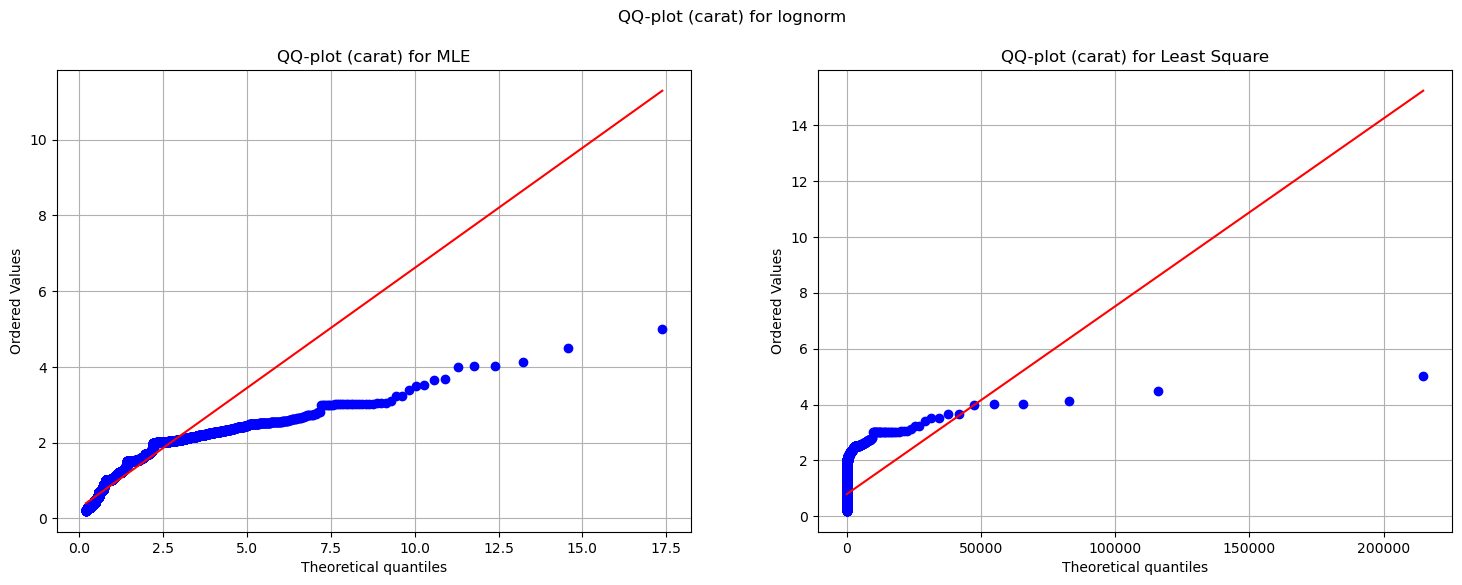

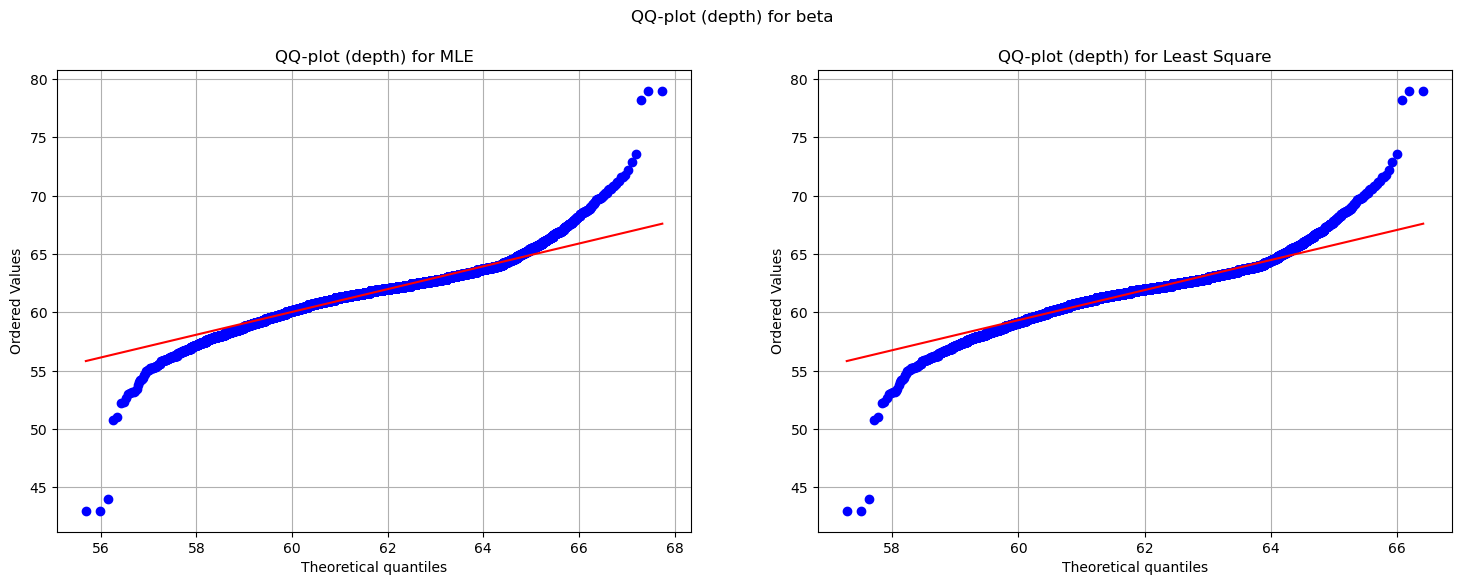

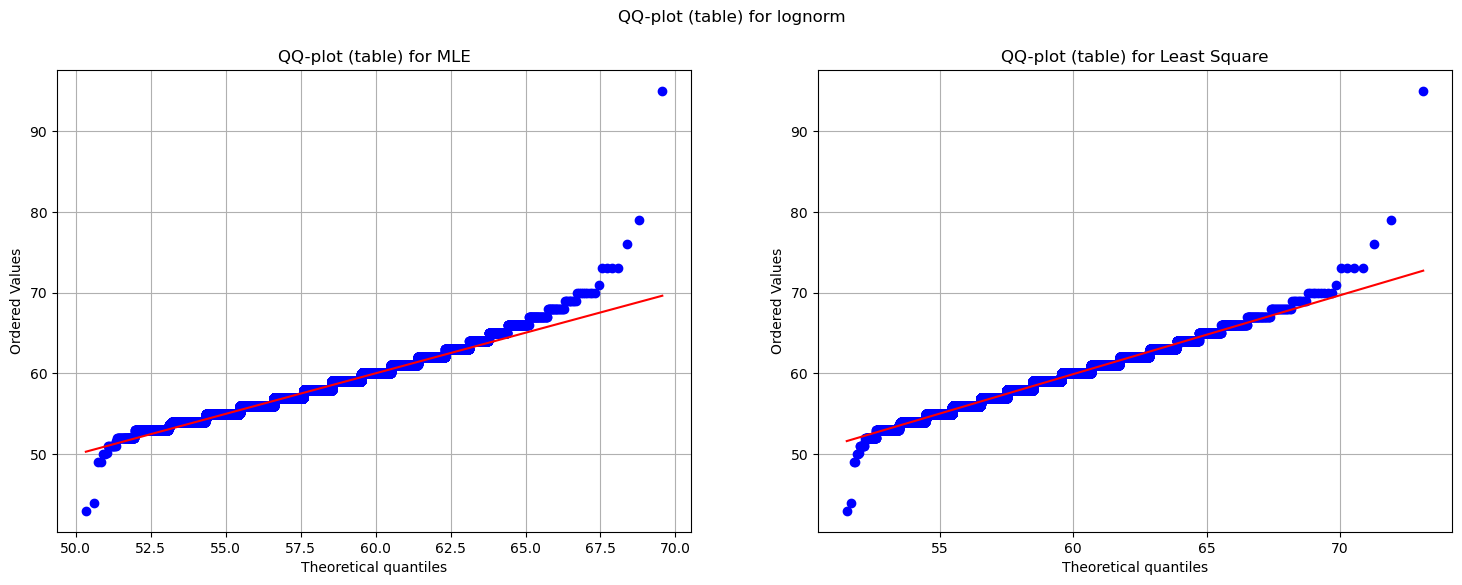

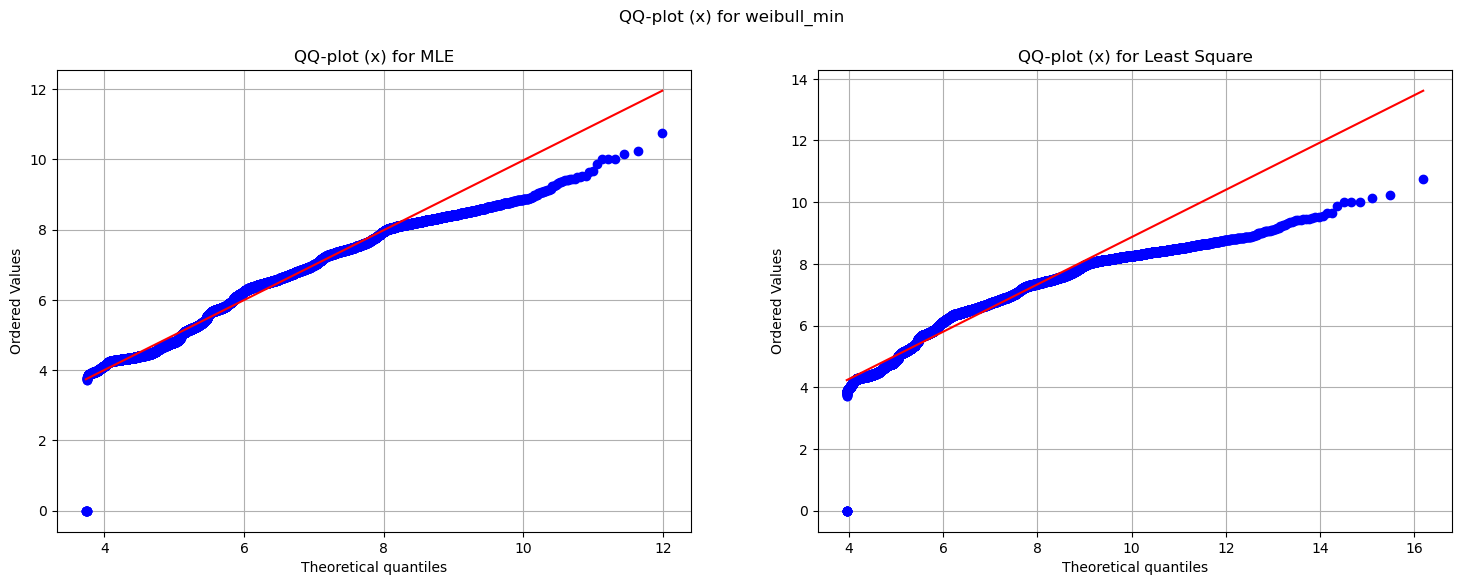

In [94]:
# Validation of estimated parameters using QQ biplots
for key, data in data_samples.items():
    qq_plot_estimation(data, data_samples_distribution[key][1], key, data_samples_distribution[key][0])

### As we can see, our distribution that we chose by MLE and LSE perfectly fit our empirical distribution. However Least Square with lognorm distribution doesn't fits good column Carat and we can see with other columns the same situation but not so obviusly
### Also we should check how theoretical distribution is really fit the data by several statistical tests.

## **7) Correctness estimation of fitted distributions using at least 2 statistical tests**

### To estimate fitted distributuions we chose 2 statistical tests: Kolmogorov-Smirnov and Cramér-von Mises for continues variables. For discrete varible we used Chi 

### Add some information about used tests:
* #### Kolmogorov-Smirnov
* #### Cramér-von Mises
* #### Chi-square
* #### Cressie-Read power divergence statistic

In [49]:
# Calculation of the Kolmogorov-Smirnov test,
data_estimated_test = pd.DataFrame{}
for key, data in data_samples.items():
    # The distribution parameters are determined using the fit function based on the maximum likelihood method
    params_mle = data_samples_distribution[key][1].fit(data)
    params_ls = ls_params(data_samples_distribution[key][0], data)

    ks_mle = stats.kstest(data, data_samples_distribution[key][0], params_mle, N=100)
    cvm_mle = stats.cramervonmises(data, data_samples_distribution[key][0], params_mle)

    ks_ls = stats.kstest(data, data_samples_distribution[key][0], params_ls, N=100)
    cvm_ls = stats.cramervonmises(data, data_samples_distribution[key][0], params_ls)

    
    # print(f'Kolmogorov-Smirnov test for {key} with fitted distribution:\n statistic = {ks.statistic}, p-value = {ks.pvalue}')
    # print(f'Cramér-von Mises test for {key} with fitted distribution:\n statistic = {cvm.statistic}, p-value = {cvm.pvalue}\n')

Kolmogorov-Smirnov test for carat with fitted distribution:
 statistic = 0.11642791033981836, p-value = 0.0
Cramér-von Mises test for carat with fitted distribution:
 statistic = 134.06111142246212, p-value = 2.7943867553226198e-08

Kolmogorov-Smirnov test for depth with fitted distribution:
 statistic = 0.07539455428174535, p-value = 4.046893205096199e-267
Cramér-von Mises test for depth with fitted distribution:
 statistic = 87.4606201974879, p-value = 3.805308579352129e-08

Kolmogorov-Smirnov test for table with fitted distribution:
 statistic = 0.10860901513683796, p-value = 0.0
Cramér-von Mises test for table with fitted distribution:
 statistic = 95.82705387601138, p-value = 4.3215851674993644e-08

Kolmogorov-Smirnov test for x with fitted distribution:
 statistic = 0.07410904891822648, p-value = 4.312631848717257e-258
Cramér-von Mises test for x with fitted distribution:
 statistic = 81.99993085340272, p-value = 1.5077500359339524e-08



### Both Kolmogorov-Smirnov and Cramér-von Mises test show us that theoretical distributions fit our data. For each test value of p-value less than 0.05 (0.95 )

# Conclusion